# Compare Usage of Bike Share Program Among Users

### Statistical Inference study on Weather Conditions Collected from a Bike Sharing Service

##### Authors: Alex Bastin, Amy Zhong, Naaimur Reza & Jeffrey Gao

### Introduction

Bike sharing systems are a new transformational method of transportation wherein the whole process from membership, rental, and return has become automatic.

These bikes bring an array of sensors and are able to collect an abundance of user usage data including weather data, like temperature and humidity; timing data, like day and time; and user data, like count of casual user daily usage. The dataset identified in this study is from a two-year study of the Capital Bikeshare system program in Washington, D.C. during 2011 and 2012 (Fanaee-T & Gama, 2013). The dataset contains 731 days of data wherein each has 17 variables. The objective of this analysis is to determine through empirical methods if “registered” users of the Capital Bikeshare program have higher rates of usage during the work week than “casual” users to a degree of statistical significance. We will quantify this usage with proportion mean as a location parameter and standard deviation as the scale parameter.

For our analysis, two academic studies are deemed relevant. Kim (2018) found demand for bike rental usage is significantly more inelastic to heat on working days than non-working days. We believe it indicates this inelastic sub-population likely are commuters that rely on the service to arrive at work. In contrast, Hosford (2018) found that the implementation of a bike share program has little impact on increasing bikeshare program usage rates both among registered and casual users in the long-term.

### Objective

For this project, we find out if there is a significant difference in the proportions of registered bike rental for workday or holiday. We want to address this question by conducting a hypothesis test. The two following parameters are useful in answering our question. 
1. We can group by the workingday variable and calculate the proportions of casual bike rental for two groups.
2. We can combine the weekday variable from Monday to Friday into one category and Saturday to Sunday into the other category to calculate the proportions of casual bike rental for two groups.

### Preliminary Results

In [1]:
# First, we will load required packages
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(dplyr)
library(broom)
library(datateachr)
require(gridExtra)


# Then, set the seed
# set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




#### I. loads data from the original source on the web

In [2]:
# URL
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"

# Download the dataset from the web
destfile <- "data/localfile.zip"
download.file(url, destfile)

# Unzip the file
unzip("data/localfile.zip", exdir = "data/")          

#### II. Clean and wrangle data into a tidy format

In [3]:
# Convert from csv to a dataframe
weather_data <- read.csv("data/day.csv")

# Clean up and wrangle
weather_data$workingday <- as_factor(weather_data$workingday)
weather_data$season <- as_factor(weather_data$season)
levels(weather_data$season) <- c("Winter","Spring","Summer","Fall")
levels(weather_data$workingday) <- c("no","yes")
weather_mutated_data <- weather_data %>% mutate(prop = registered/cnt)

head(weather_mutated_data)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,prop
,<int>,<chr>,<fct>,<int>,<int>,<int>,<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>
1,1,2011-01-01,Winter,0,1,0,6,no,2,0.344167,0.363625,0.805833,0.1604460,331,654,985,0.6639594
2,2,2011-01-02,Winter,0,1,0,0,no,2,0.363478,0.353739,0.696087,0.2485390,131,670,801,0.8364544
3,3,2011-01-03,Winter,0,1,0,1,yes,1,0.196364,0.189405,0.437273,0.2483090,120,1229,1349,0.9110452
4,4,2011-01-04,Winter,0,1,0,2,yes,1,0.200000,0.212122,0.590435,0.1602960,108,1454,1562,0.9308579
5,5,2011-01-05,Winter,0,1,0,3,yes,1,0.226957,0.229270,0.436957,0.1869000,82,1518,1600,0.9487500
6,6,2011-01-06,Winter,0,1,0,4,yes,1,0.204348,0.233209,0.518261,0.0895652,88,1518,1606,0.9452055


#### IV. Compute estimates

We are interested in the proportions of registered bike rental in winter and summer.

In [4]:
## Filter and select the data in winter
registered_prop_winter <-
    weather_mutated_data %>%
    filter(season == "Winter") %>%
    select(workingday, prop, season)

head(registered_prop_winter)

sample_summary_winter <-
    registered_prop_winter %>%
    group_by(workingday) %>%
    summarize(mean = mean(prop),
              n = n(),
              sd = sd(prop),
              `.groups` = "drop") %>%
    pivot_wider(names_from = workingday, values_from = c(n, sd, mean)) %>% 
    mutate(mean_diff = mean_yes - mean_no)

sample_summary_winter

,workingday,prop,season
,<fct>,<dbl>,<fct>
1,no,0.6639594,Winter
2,no,0.8364544,Winter
3,yes,0.9110452,Winter
4,yes,0.9308579,Winter
5,yes,0.9487500,Winter
6,yes,0.9452055,Winter


n_no,n_yes,sd_no,sd_yes,mean_no,mean_yes,mean_diff
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
61,120,0.1083181,0.04706721,0.7871169,0.9219079,0.134791


In [5]:
## Filter and select the data in summer
registered_prop_summer <-
    weather_mutated_data %>%
    filter(season == "Summer") %>%
    select(workingday, prop, season)

head(registered_prop_summer)

sample_summary_summer <-
    registered_prop_summer %>%
    group_by(workingday) %>%
    summarize(mean = mean(prop),
              n = n(),
              sd = sd(prop),
              `.groups` = "drop") %>%
    pivot_wider(names_from = workingday, values_from = c(n, sd, mean)) %>% 
    mutate(mean_diff = mean_yes - mean_no)

sample_summary_summer

,workingday,prop,season
,<fct>,<dbl>,<fct>
1,yes,0.8399173,Summer
2,yes,0.8533393,Summer
3,yes,0.8442589,Summer
4,yes,0.8058505,Summer
5,no,0.6574394,Summer
6,no,0.6380773,Summer


n_no,n_yes,sd_no,sd_yes,mean_no,mean_yes,mean_diff
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
57,131,0.05919498,0.02988689,0.6578987,0.8421875,0.1842887


#### V. Plots

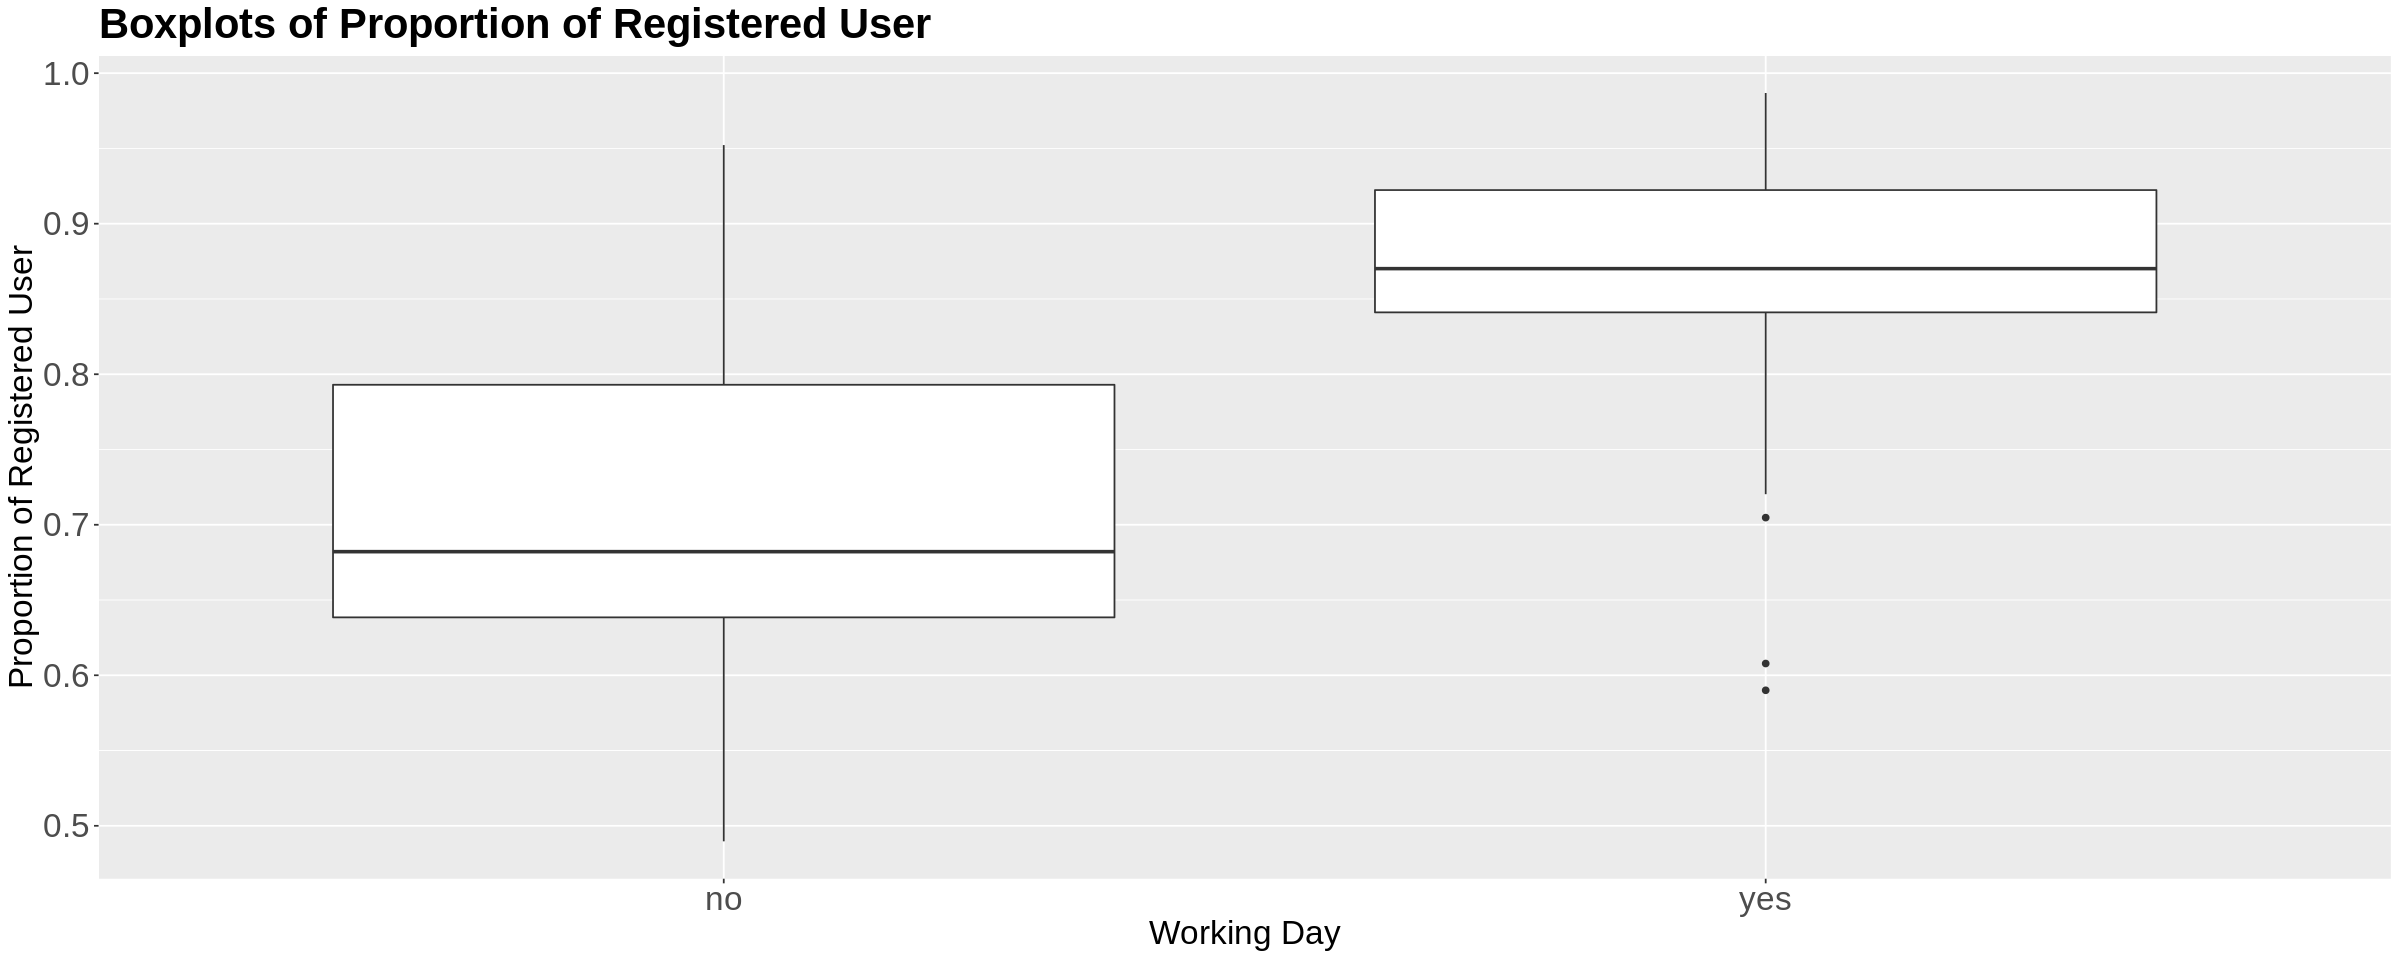

In [6]:
options(repr.plot.width = 20, repr.plot.height = 8)

# Distribution of proportion of raw data

boxplots <- 
    weather_mutated_data %>%  
    ggplot(aes(x = workingday, y = prop)) + 
    geom_boxplot() + 
    xlab("Working Day") +
    ylab("Proportion of Registered User") +
ggtitle("Boxplots of Proportion of Registered User")+
theme(plot.title = element_text(size = 25, face = "bold"), axis.title=element_text(size=20), text = element_text(size=25))


boxplots

### Methods: Plan

Throughout our analysis we hold the null hypothesis that registered and casual users have identical usage rates independent of the day of the week. Based on aforementioned academic research and our intuition as researchers, we set the alternative hypothesis that the proportion of registered users that use the bike share system is higher than casual users during the work week to a significant degree.

The sample size used for our plots and estimates was large enough to produce close to accurate results. The use of bootstrap sampling has made it easier to derive the estimates for the proportions without having to use the entire sample or having the need to collect more data. Even though the results produced are good estimates they are not strong enough to prove or provide anything substantial. Calculating the 90% confidence interval for the average proportions of registered users will provide a range within which there would be a 90% chance of having the true proportions. We expect to find the two proportions are significantly different from each other. We expect to disprove the null hypothesis and accept the alternate hypothesis.

##### Expectation

We expect to find estimates for the proportion of each weather condition in spring and winter and their respective 90% confidence intervals. Conduct hypothesis tests to find out if there are significant differences between the proportions of weather conditions for each season. We then further develop the trust of our report by offering measures of statistical significance, P-values.

##### Impact

This analysis could prove beneficial for marketing departments to better define target markets and allocate marketing efforts, or to better inform the placement of new automated bike racks to optimize for registered users.

Future question that might come up due to our study include: 
1. Are there any other factors that draw the interest of the registered user?   
2. Does weather affect the consumer behaviour of the registered user?
3. What factors draw the interest of casual users?

### Hypothesis Test

We are going to test the winter sample first.

In [7]:
## calculate the test statistics
test_stat_winter <-
    registered_prop_winter %>%
    specify(formula = prop ~ workingday) %>%
    calculate(stat = "diff in means", order = c("yes", "no"))

test_stat_winter

stat
<dbl>
0.134791


In [8]:
## build a null model
null_model_winter <-
    registered_prop_winter %>%
    specify(formula = prop ~ workingday) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 1000, type = "permute") %>%
    calculate(stat = "diff in means", order = c("yes", "no"))

head(null_model_winter)

replicate,stat
<int>,<dbl>
1,0.0105464514
2,-0.0310648482
3,-0.0253688978
4,0.0026385245
5,-0.0005005056
6,0.0038826116


In [9]:
## get the p value
p_value_winter <- 
    null_model_winter %>%
    get_p_value(obs_stat = test_stat_winter, direction = "two_sided")

p_value_winter

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


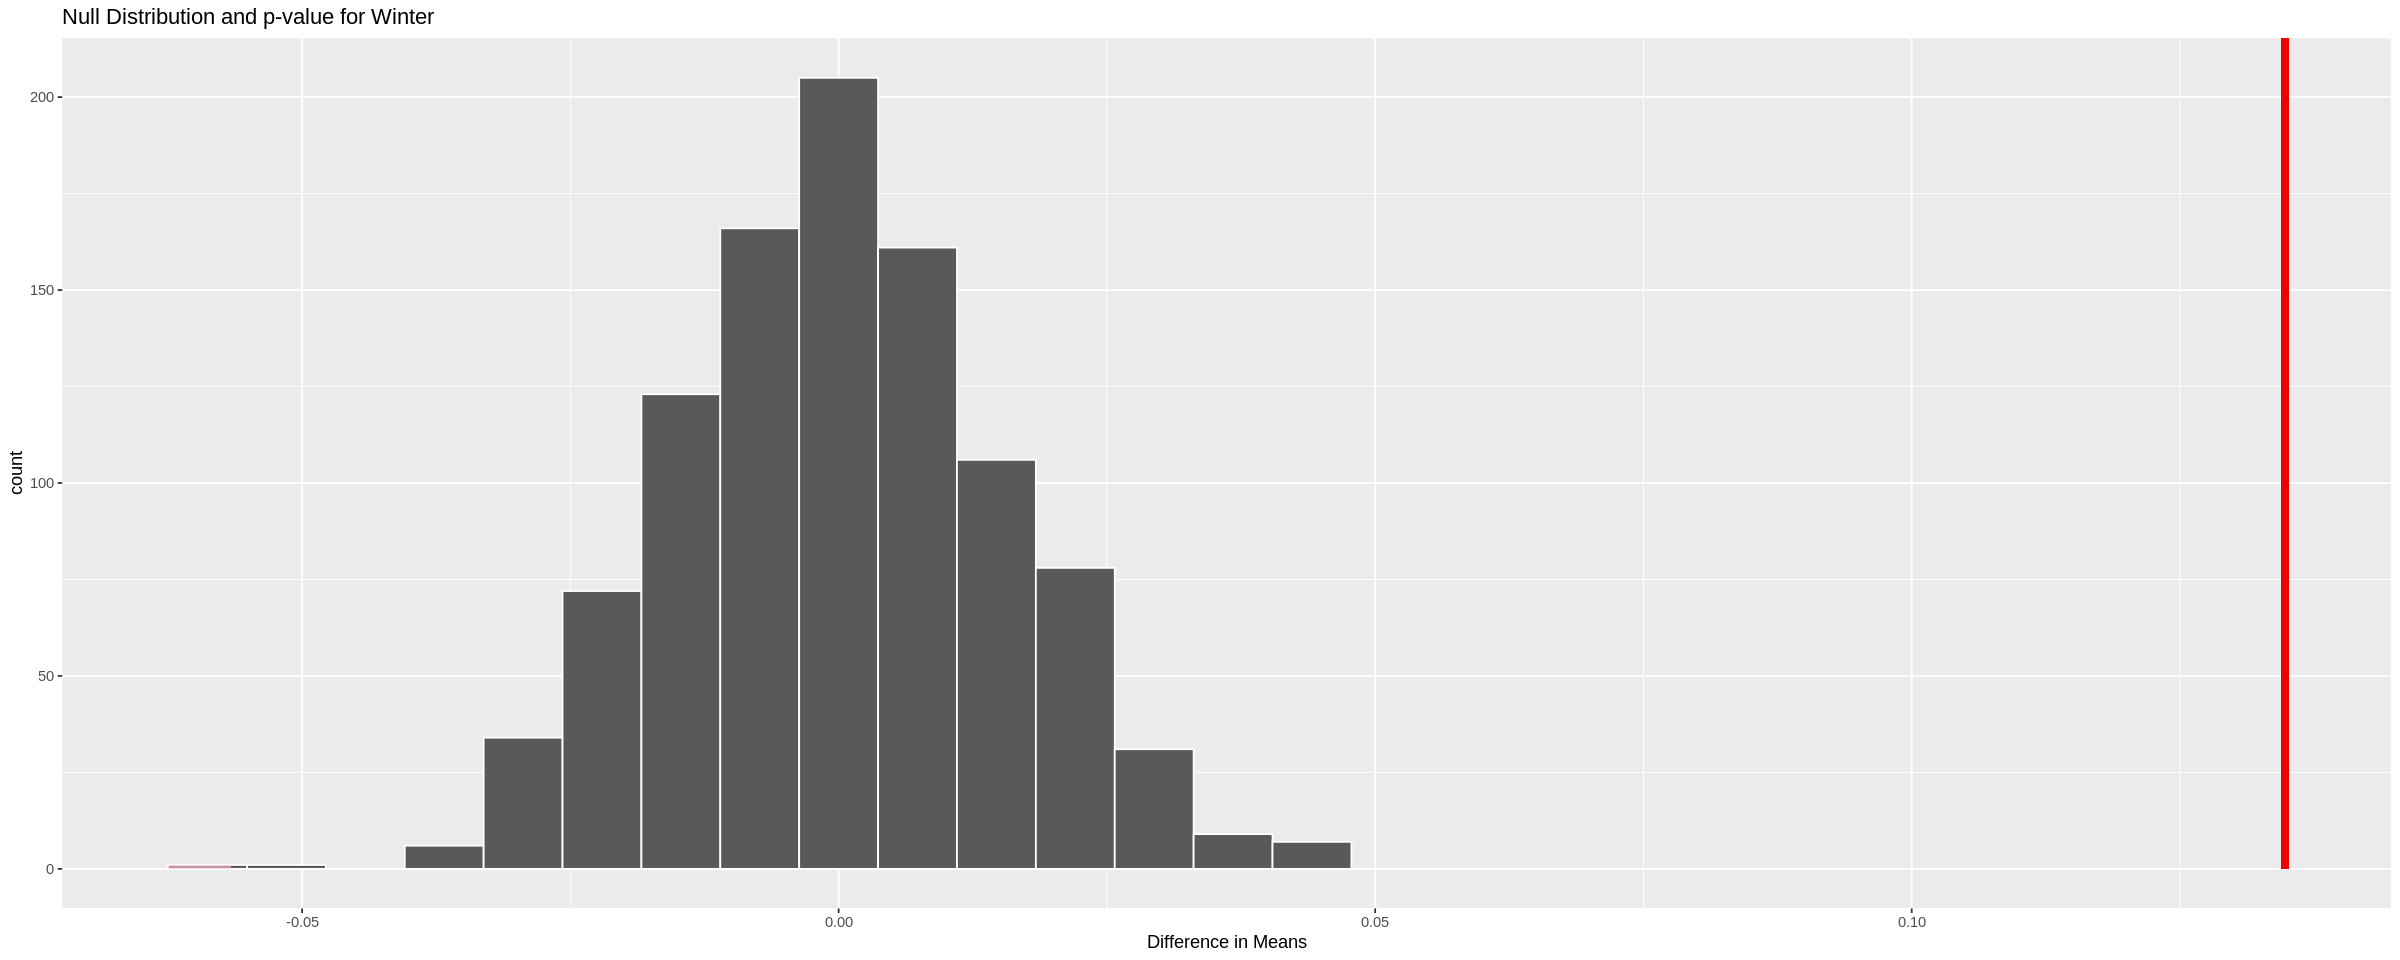

In [10]:
## plot the null model and the p-value
registered_plot_winter <-
    null_model_winter %>%
    visualize() +
    shade_p_value(obs_stat = test_stat_winter, direction = "two_sided") +
    labs(x = "Difference in Means") +
    ggtitle("Null Distribution and p-value for Winter")

registered_plot_winter

### Theory-based Test

Here, we need to use the t-distribution. We need to check the assumptions for t-distribution.

1. <b>The population is normally distributed</b>. We do not have full access to the population, so we cannot assume the population is normally distributed.
2. <b>The population is not normally distributed</b>. We need to check if the Central Limit Theorem is valid here. Our sample sizes are large enough with each of them exceed size 50.

We are going to test the winter sample first.

In [11]:
## calculate the test statistics
sample_summary_winter <-
    sample_summary_winter %>%
    mutate(mean_diff = mean_yes - mean_no) %>%
    mutate(null_std_error = sqrt(sd_yes^2/n_yes + sd_no^2/n_no)) %>%
    mutate(test_stat = mean_diff/null_std_error)

sample_summary_winter

n_no,n_yes,sd_no,sd_yes,mean_no,mean_yes,mean_diff,null_std_error,test_stat
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
61,120,0.1083181,0.04706721,0.7871169,0.9219079,0.134791,0.01451902,9.283751


In [12]:
## calculate the p-value
sample_summary_winter <- mutate(sample_summary_winter, p_value = 2*pt(test_stat, df = nrow(registered_prop_winter) - 1, lower.tail = FALSE))

sample_summary_winter

n_no,n_yes,sd_no,sd_yes,mean_no,mean_yes,mean_diff,null_std_error,test_stat,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
61,120,0.1083181,0.04706721,0.7871169,0.9219079,0.134791,0.01451902,9.283751,5.263569e-17


In [13]:
## perform the t-test

working_winter <- filter(registered_prop_winter, workingday == "yes")
nonworking_winter <- filter(registered_prop_winter, workingday == "no")
registered_t_test <- tidy(t.test(x = working_winter$prop, y = nonworking_winter$prop, alternative = "two.sided"))

registered_t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.134791,0.9219079,0.7871169,9.283751,6.409996e-14,71.73721,0.105846,0.163736,Welch Two Sample t-test,two.sided


### Bootstrapping

In [14]:
## create a bootstrap distribution
resampled_winter <-
    registered_prop_winter %>%
    specify(response = prop) %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "mean")

head(resampled_winter)

replicate,stat
<int>,<dbl>
1,0.8896202
2,0.8837105
3,0.8817722
4,0.8783300
5,0.8792190
6,0.8728845


In [15]:
## get the 95% confidence interval
percentile_ci_winter <- get_confidence_interval(resampled_winter, level = 0.95, type ="percentile")

percentile_ci_winter 

lower_ci,upper_ci
<dbl>,<dbl>
0.8615524,0.8907668


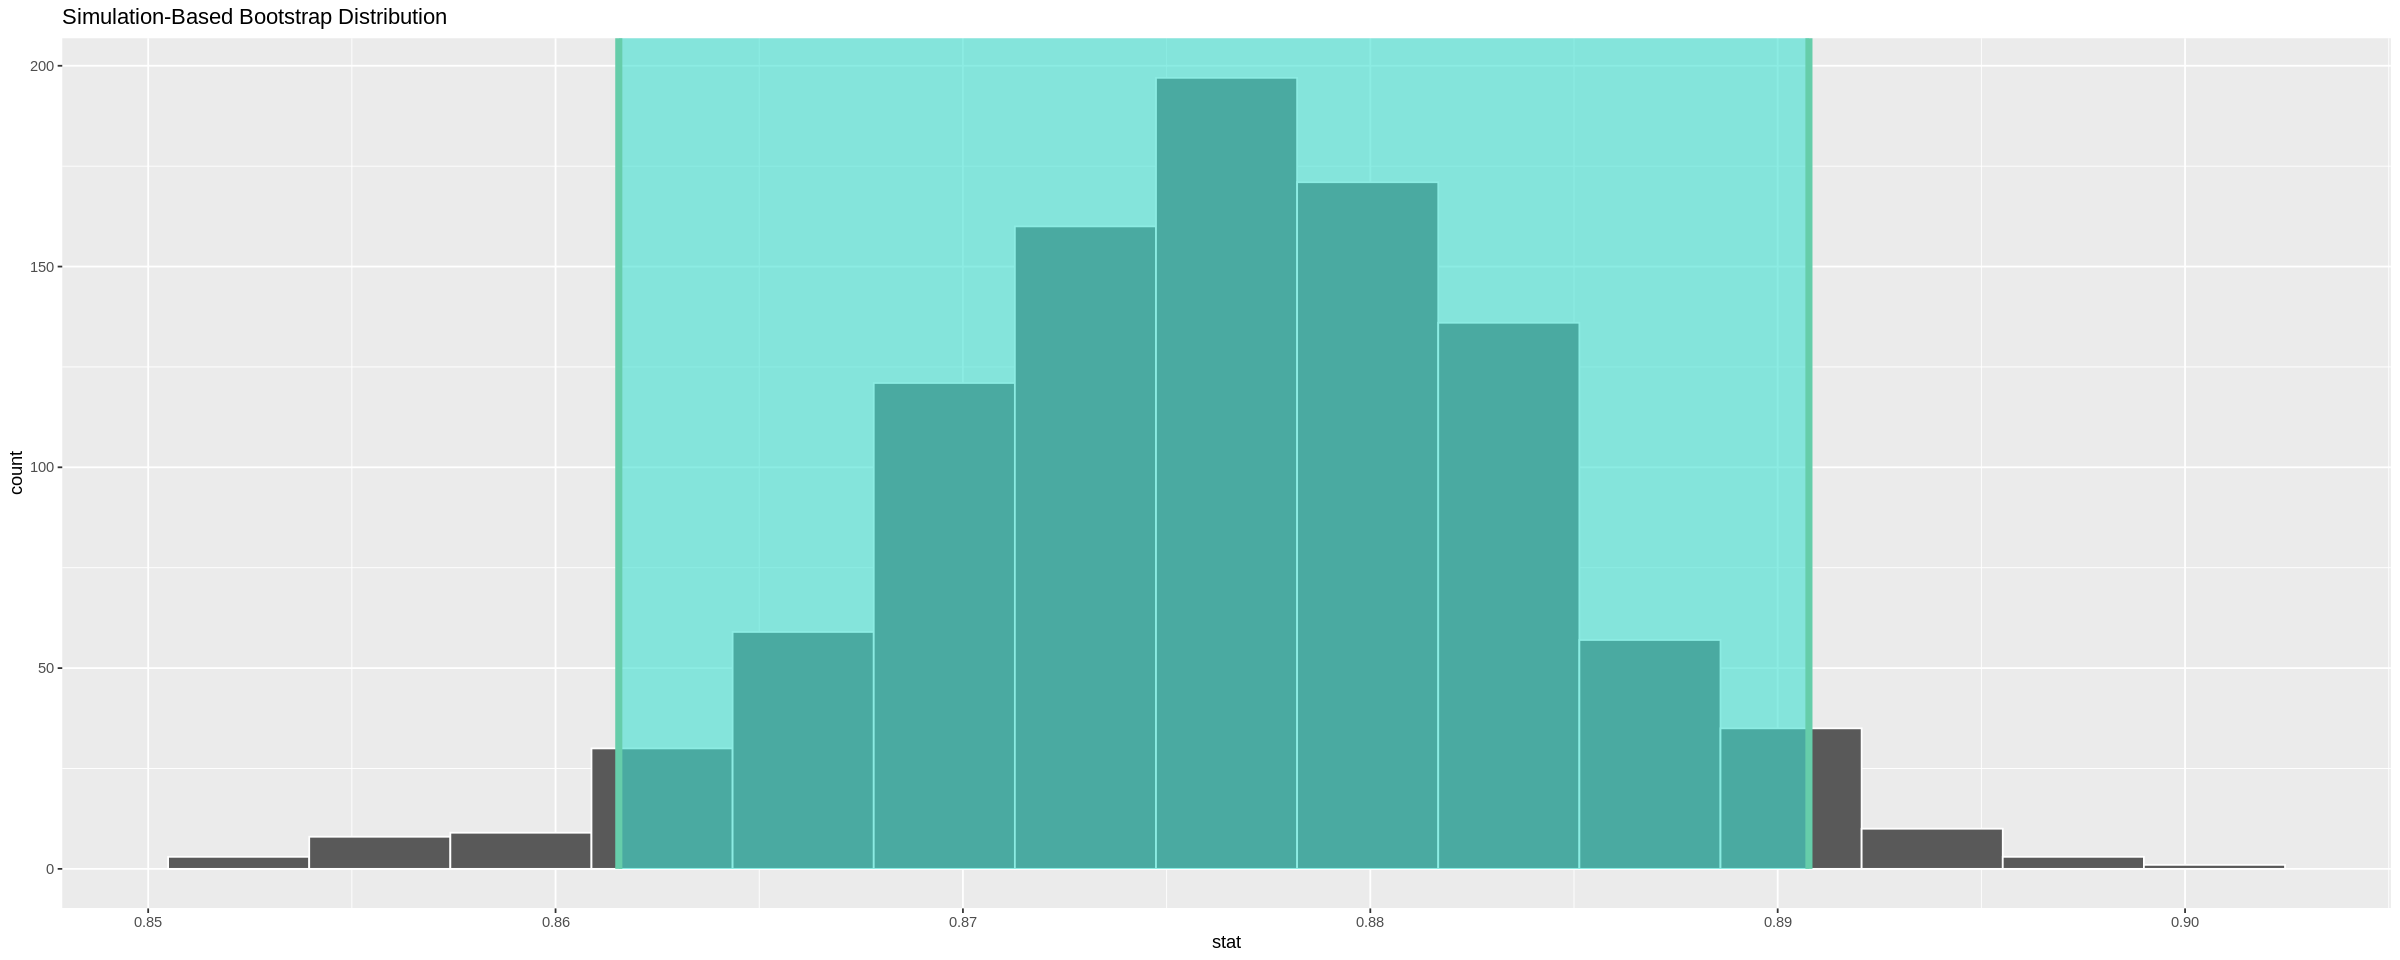

In [16]:
## visualize the bootstrap distribution

visualize(resampled_winter) +    
shade_confidence_interval(endpoints = percentile_ci_winter)

##### Interpretation of Confidence Interval

We are 95% confident that the true value of the mean proportions of registered users in winter is between 0.8618008 and 0.8895404.

### Hypothesis Test

Now the same thing, but with the summer sample.

In [17]:
## calculate the test statistics
test_stat_summer <-
    registered_prop_summer %>%
    specify(formula = prop ~ workingday) %>%
    calculate(stat = "diff in means", order = c("yes", "no"))

test_stat_summer

stat
<dbl>
0.1842887


In [18]:
## build a null model
null_model_summer <-
    registered_prop_summer %>%
    specify(formula = prop ~ workingday) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 1000, type = "permute") %>%
    calculate(stat = "diff in means", order = c("yes", "no"))

head(null_model_summer)

replicate,stat
<int>,<dbl>
1,0.008072335
2,0.006766963
3,-0.027244040
4,0.002953028
5,-0.015539756
6,-0.007891357


In [19]:
## get the p value
p_value_summer <- 
    null_model_summer %>%
    get_p_value(obs_stat = test_stat_summer, direction = "two_sided")

p_value_summer

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


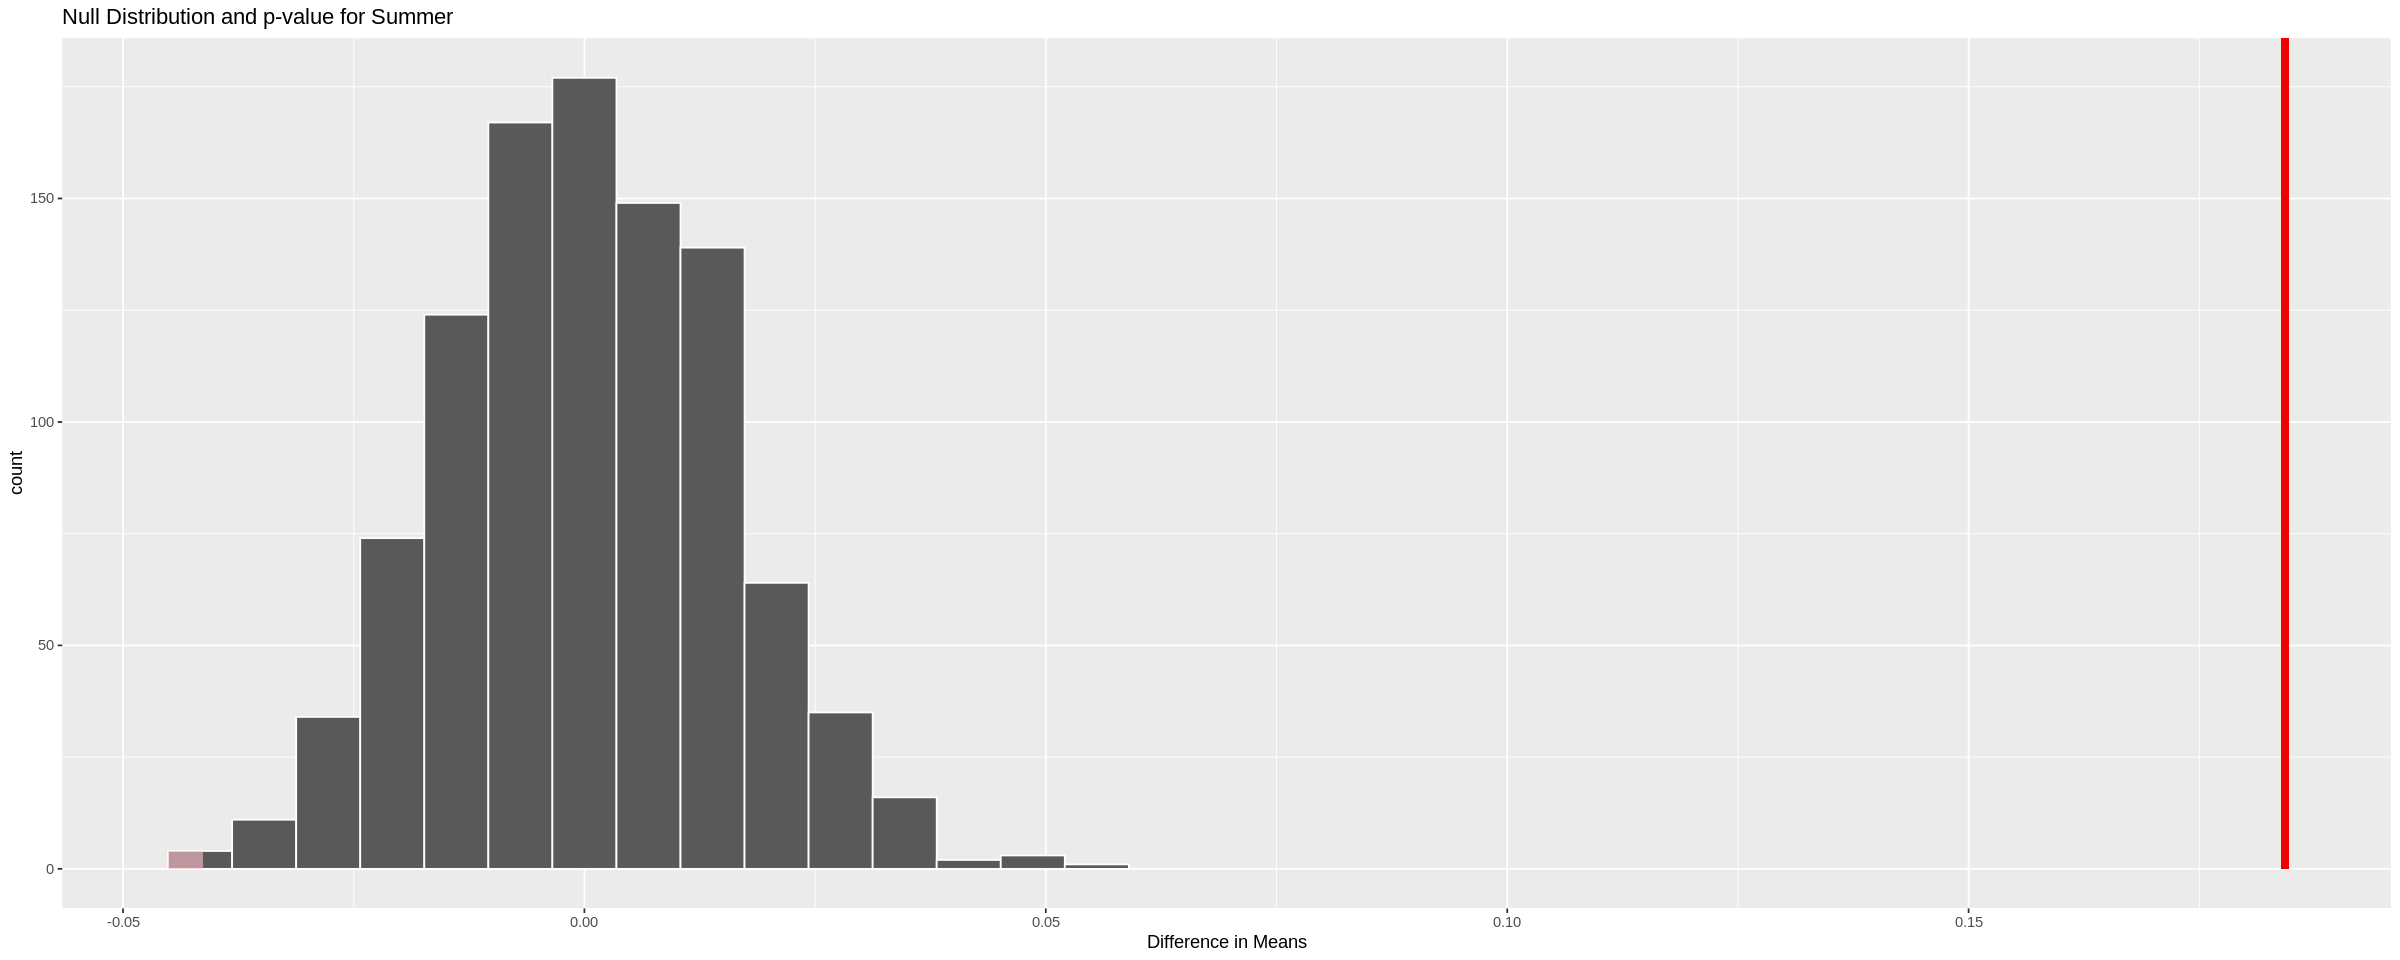

In [20]:
## plot the null model and the p-value
registered_plot_summer <-
    null_model_summer %>%
    visualize() +
    shade_p_value(obs_stat = test_stat_summer, direction = "two_sided") +
    labs(x = "Difference in Means") +
    ggtitle("Null Distribution and p-value for Summer")

registered_plot_summer

### Theory-based Test

Here, we need to use the t-distribution. We need to check the assumptions for t-distribution.

1. <b>The population is normally distributed</b>. We do not have full access to the population, so we cannot assume the population is normally distributed.
2. <b>The population is not normally distributed</b>. We need to check if the Central Limit Theorem is valid here. Our sample sizes are large enough with each of them exceed size 50.

Testing the summer sample:

In [21]:
## calculate the test statistics
sample_summary_summer <-
    sample_summary_summer %>%
    mutate(mean_diff = mean_yes - mean_no) %>%
    mutate(null_std_error = sqrt(sd_yes^2/n_yes + sd_no^2/n_no)) %>%
    mutate(test_stat = mean_diff/null_std_error)

sample_summary_summer

n_no,n_yes,sd_no,sd_yes,mean_no,mean_yes,mean_diff,null_std_error,test_stat
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
57,131,0.05919498,0.02988689,0.6578987,0.8421875,0.1842887,0.008263959,22.3003


In [22]:
## calculate the p-value
sample_summary_summer <- mutate(sample_summary_summer, p_value = 2*pt(test_stat, df = nrow(registered_prop_summer) - 1, lower.tail = FALSE))

sample_summary_summer

n_no,n_yes,sd_no,sd_yes,mean_no,mean_yes,mean_diff,null_std_error,test_stat,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
57,131,0.05919498,0.02988689,0.6578987,0.8421875,0.1842887,0.008263959,22.3003,1.429994e-54


In [23]:
## perform the t-test

working_summer <- filter(registered_prop_summer, workingday == "yes")
nonworking_summer <- filter(registered_prop_summer, workingday == "no")
registered_t_test <- tidy(t.test(x = working_summer$prop, y = nonworking_summer$prop, alternative = "two.sided"))

registered_t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.1842887,0.8421875,0.6578987,22.3003,3.439724e-33,68.74723,0.1678015,0.200776,Welch Two Sample t-test,two.sided


### Bootstrapping

In [24]:
## create a bootstrap distribution
resampled_summer <-
    registered_prop_summer %>%
    specify(response = prop) %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "mean")

head(resampled_summer)

replicate,stat
<int>,<dbl>
1,0.7870982
2,0.7768266
3,0.7846289
4,0.7960443
5,0.7804343
6,0.7848616


In [25]:
## get the 95% confidence interval
percentile_ci_summer <- get_confidence_interval(resampled_summer, level = 0.95, type ="percentile")

percentile_ci_summer 

lower_ci,upper_ci
<dbl>,<dbl>
0.7725455,0.7987492


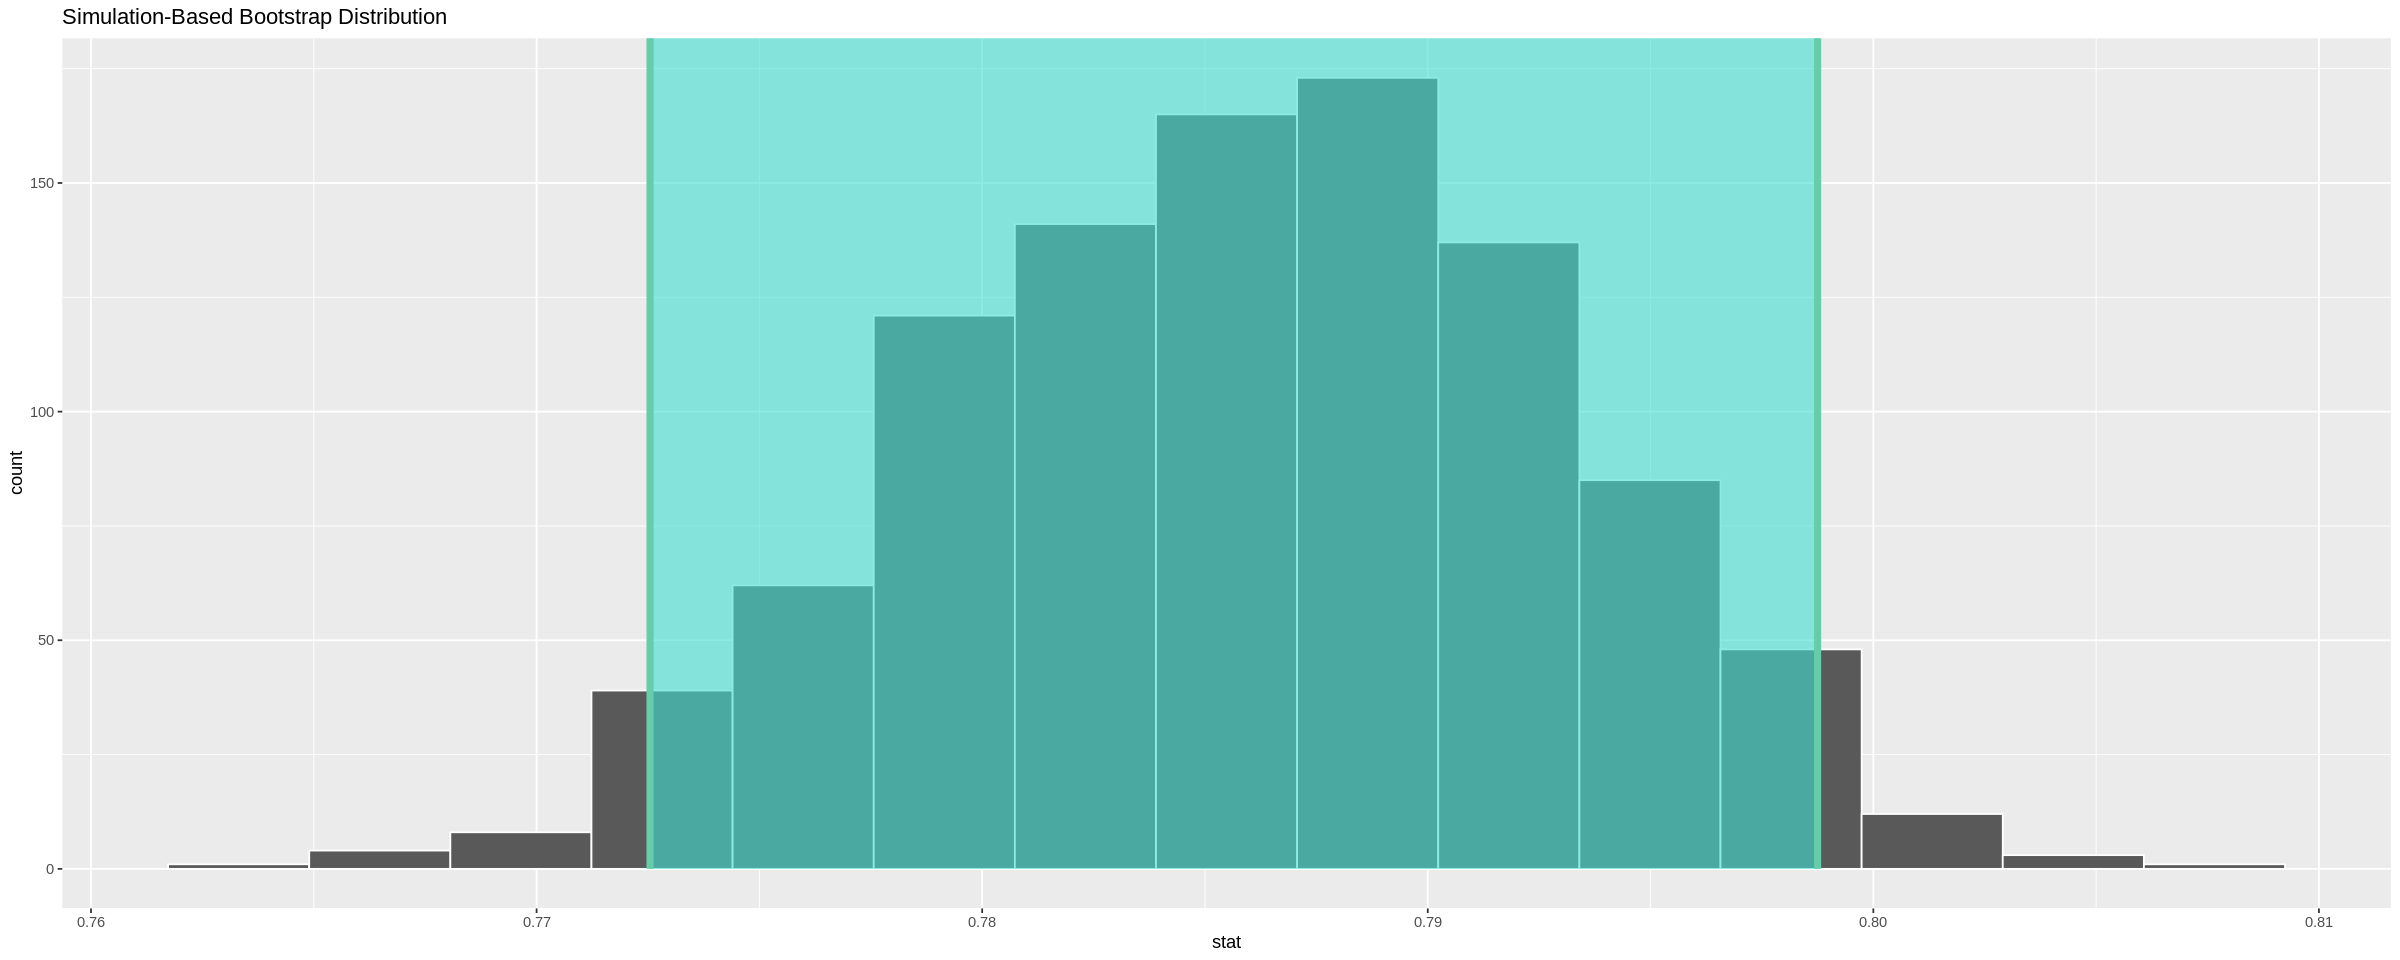

In [26]:
## visualize the bootstrap distribution

visualize(resampled_summer) +    
shade_confidence_interval(endpoints = percentile_ci_summer)

##### Interpretation of Confidence Interval

We are 95% confident that the true value of the mean proportions of registered users in summer is between 0.7725455 and 0.7987492.

### References

Hadi Fanaee-T, Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto 

<em>"Using weather forecast to forecast whether bikes are used"<em> by Jan Wessel

<em>"The AI forecaster: Machine learning takes on weather prediction"<em> by Aaron Sidder, American Geophysical Union

<em>REFERENCES Kim, K. (2018, January). Investigation on the effects of weather and calendar events on bike-sharing according to the trip patterns of bike rentals of stations. ScienceDirect. Retrieved July 25, 2022, from https://doi.org/10.1016/j.jtrangeo.2018.01.001

Hosford, K. (2018, December). Evaluation of the impact of a public bicycle share program on population bicycling in Vancouver, BC. ScienceDirect. Retrieved July 26, 2022, from https://doi.org/10.1016/j.pmedr.2018.09.014

Fanaee-T, H., & Gama, J. (2013, November 26). Event labeling combining ensemble detectors and background knowledge - progress in Artificial Intelligence. SpringerLink. Retrieved July 25, 2022, from https://link.springer.com/article/10.1007/s13748-013-0040-3